### Agentic RAG
#### RAG (Retrieval-Augmented Generation):
- RAG is a technique where a retriever fetches relevant information from external knowledge sources (like a vector database, documents, APIs), and then a generator (LLM) uses this context to produce accurate and up-to-date answers.  

👉 Limitation: Traditional RAG is static. It retrieves once, feeds the result to the LLM, and generates an answer. If retrieval fails (wrong doc, incomplete info), the model may hallucinate or produce poor answers.  

#### Agentic RAG (Agent + RAG):
Agentic RAG enhances this by turning the LLM into an autonomous agent that can:
- Reason about whether retrieved information is sufficient.
- Decide actions dynamically (e.g., re-query, filter, call tools, ask clarifying questions).
- Iterate until it gathers the right information before generating the final answer.
- Use multiple tools (search, APIs, calculators, SQL queries, etc.) in addition to retrieval.
Essentially, Agentic RAG = RAG + Agency (decision-making loop).  

#### Example Flow (Traditional vs Agentic RAG):
🔹 **Traditional RAG**
- User: “What are the latest treatments for Type 2 Diabetes?”
- System: Retrieves 3 documents → feeds to LLM → generates answer (may be outdated if docs are stale).  

🔹 **Agentic RAG**
- LLM acts as an agent:
    1. Retrieves docs.
    2. Realizes results are from 2022 only.
    3. Decides to re-query with “Type 2 Diabetes treatment 2023 2024 site:pubmed.gov”.
    4. Fetches newer research papers.
    5. Summarizes & cites.
- User gets a reliable, updated answer.
    
- **Summary**: Agentic RAG is Retrieval-Augmented Generation combined with an agentic loop, where the LLM doesn’t just consume retrieved context passively but actively decides how to retrieve, re-query, call external tools, and iterate until it gathers the right knowledge before responding. It reduces hallucination and makes AI systems more accurate, adaptive, and reliable for enterprise use cases.

#### Why It Matters
- Improves accuracy (less hallucination).
- Enables multi-step reasoning.
- Can handle dynamic knowledge sources (databases, APIs).
- Used in production-grade AI apps like copilots, research assistants, BFSI/healthcare chatbots.

In [17]:
# Imports
from typing import Annotated, List, Sequence
import operator
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
import os

# Load LLM
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
api_key = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(name="gpt-5-nano", api_key=api_key)
llm.invoke("What is machine learning?")

AIMessage(content="Machine learning is a method of data analysis that involves building algorithms and statistical models that enable a computer system to learn and improve from experience without being explicitly programmed. It is a type of artificial intelligence that uses patterns and inference to make decisions and predictions based on data. Machine learning involves training algorithms to recognize patterns and make decisions based on that data, with the goal of improving the system's performance over time.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 12, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CbV4themnXjYbIpF9ljEND2bG44Xy', 'service_tier': 'default

In [6]:
# RAG imports
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
urls = ["https://docs.langchain.com/oss/python/langgraph/graph-api",
        "https://docs.langchain.com/oss/python/langgraph/functional-api"]

docs = WebBaseLoader(urls).load()
docs

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/graph-api', 'title': 'Graph API overview - Docs by LangChain', 'language': 'en'}, page_content='Graph API overview - Docs by LangChainSkip to main contentWe\'ve raised a $125M Series B to build the platform for agent engineering. Read more.Docs by LangChain home pageLangChain + LangGraphSearch...⌘KGitHubTry LangSmithTry LangSmithSearch...NavigationGraph APIGraph API overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewLangGraph v1.0Release notesMigration guideGet startedInstallQuickstartLocal serverThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureStudioTestDeployAgent Chat UIObservabilityLangGraph APIsGraph APIGraph APIUse the graph APIFunctional APIRuntimecloseOn this pageGraphsStateGraphCompiling your graphStateSchemaMultiple schemasReducersDefault ReducerOverwriteWork

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents=docs)

vectorstore = FAISS.from_documents(documents=doc_splits, embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

In [10]:
retriever.invoke("What is a StateGraph?")

[Document(id='53a347b0-32cf-4c13-8d55-8386af2d0b35', metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/graph-api', 'title': 'Graph API overview - Docs by LangChain', 'language': 'en'}, page_content='A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps. At the start of graph execution, all nodes begin in an inactive state. A node becomes active when it receives a new message (state) on any of its incoming edges (or “channels”). The active node then runs its function and responds with updates. At the end of each super-step, nodes with no incoming messages vote to halt by marking themselves as inactive. The graph execution terminates when all nodes are inactive and no messages are in transit.\n\u200bStateGraph\nThe StateGraph class is the main graph class to use. This is parameterized by a user defined State object.\n\u200bCompi

In [11]:
# Convert retriever to retriever tool
from langchain.tools.retriever import create_retriever_tool
graph_api_tool = create_retriever_tool(retriever=retriever,
                      name="GraphAPI",
                      description="Search and run information about graph api")
graph_api_tool

Tool(name='GraphAPI', description='Search and run information about graph api', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x00000144A746CA60>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000144A7808580>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x00000144A746C9D0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000144A7808580>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separat

### Create another vector store
The idea is to have 2 tools (for demo), each tool having separate vectorstore and we let LLM decide which one to query

In [12]:
url = ["https://docs.langchain.com/oss/python/langchain/agents"]
docs = WebBaseLoader(url).load()
docs

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='Agents - Docs by LangChainSkip to main contentWe\'ve raised a $125M Series B to build the platform for agent engineering. Read more.Docs by LangChain home pageLangChain + LangGraphSearch...⌘KGitHubTry LangSmithTry LangSmithSearch...NavigationCore componentsAgentsLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewLangChain v1.0Release notesMigration guideGet startedInstallQuickstartPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryUse in productionStudioTestDeployAgent Chat UIObservabilitycloseOn this pageCore componentsModelStatic modelDynamic modelToolsDefining toolsTool error

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents=docs)

vectorstore = FAISS.from_documents(documents=doc_splits, embedding=OpenAIEmbeddings())

retriever_langchain = vectorstore.as_retriever()

In [14]:
retriever_langchain.invoke("How to return structured output?")

[Document(id='79b2bd5e-2dd9-4b74-8a1f-36a72026f58e', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='promptInvocationAdvanced conceptsStructured outputToolStrategyProviderStrategyMemoryDefining state via middlewareDefining state via state_schemaStreamingMiddlewareCore componentsAgentsCopy pageCopy pageAgents combine language models with tools to create systems that can reason about tasks, decide which tools to use, and iteratively work towards solutions.'),
 Document(id='35b23a01-7328-4189-a128-13015f323a45', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='result = agent.invoke({\n    "messages": [{"role": "user", "content": "Extract contact info from: John Doe, john@example.com, (555) 123-4567"}]\n})\n\nresult["structured_response"]\n# ContactInfo(name=\'John Doe\', email=\'john@examp

In [15]:
# Convert retriever to retriever tool
from langchain.tools.retriever import create_retriever_tool
langchain_api_tool = create_retriever_tool(retriever=retriever_langchain,
                      name="LangChain",
                      description="Search and run information about Langchain")
langchain_api_tool

Tool(name='LangChain', description='Search and run information about Langchain', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x00000144A746CA60>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000014504DC4AF0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x00000144A746C9D0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000014504DC4AF0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separa

In [16]:
tools = [graph_api_tool, langchain_api_tool]

### LangGraph Workflow

In [18]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [19]:
def agent(state: AgentState):
    """
    Invokes the agent model to generate a response based on the current state.
    Given the question, it will decide to retrieve using the retriever tool, or simply end.
    
    Keyword arguments:
    state (messages) -- the current state
    Return:
    dict - The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    llm_with_tools = llm.bind_tools(tools=tools)
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [ ]:
from langchain_core.prompts import PromptTemplate
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    Determines wheather the retrieved documents are relevant to the question.
    
    Keyword arguments:
    state (messages) -- the current state
    Return:
    str - A decision for wheather the documents are relevant or not
    """
    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    llm_with_tool = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader, assessing the relevance of the retrieved documents to the user questions.\n
        Here is the retrieved document: \n {context} \n\n
        Here is the question: {question} \n
        If the documents contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"]
        )
    
    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    score_result = chain.invoke({"context": docs, "question": question})
    score = score_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"



In [40]:
from langchain_core.output_parsers import StrOutputParser

def generate(state: AgentState):
    """Generate answer
    
    Keyword arguments:
    state (messages) -- the current state
    Return:
    dict - The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    prompt = PromptTemplate.from_template(template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question} 
    Context: {context}
    Answer:
    """)

    rag_chain = prompt | llm | StrOutputParser()
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


In [41]:
def rewrite(state:AgentState):
    """Transform the query to produce a better question
    
    Keyword arguments:
    state (messages) -- the current state
    Return:
    dict: The updated state with re-phrased question
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent/meaning. \n
        Here is the initial question:
        \n ------- \n
        {question}
        \n ------- \n
        Formulate an improved question: 
        """
        )
    ]

    response = llm.invoke(msg)
    return {"messages": [response]}


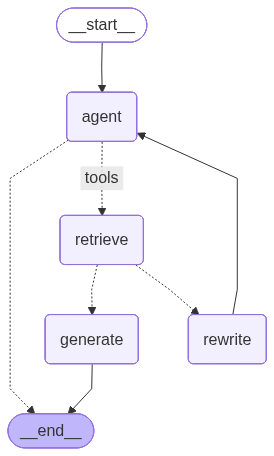

In [42]:
# Define state graph and workflow
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate", generate)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tools_condition, {
    "tools": "retrieve",
    END: END
})

workflow.add_conditional_edges("retrieve", grade_documents,
{
    "generate":"generate",
    "rewrite":"rewrite"
})
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

graph = workflow.compile()

# View graph
graph_image = graph.get_graph(xray=True).draw_mermaid_png()
display(Image(graph_image))

In [43]:
graph.invoke({"messages": "What are different ways to define State Schema?"})

---CALL AGENT---
---CHECK RELEVANCE---


c:\MyDrive\SelfStudyCode\AI\Krish\AgenticAI\venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What are different ways to define State Schema?', additional_kwargs={}, response_metadata={}, id='37d18340-283b-4b1d-9063-345c0963f1b5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yemfVhMqRxWhrU4tELybjire', 'function': {'arguments': '{"query":"State Schema"}', 'name': 'GraphAPI'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 98, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CbdsW15HgP4h2j94TEL2dYqu0kjKd', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6f4a8b6b-1cd1-4cd1-be56-171d4dd5c109-0', tool_calls=[{'name': 'GraphAPI', 'args': {'query': 'State Schema'}